# Implementing and Training Convolutional Conditional Neural Processes

The ConvCNP ([Convolutional Conditional Neural Process](https://openreview.net/forum?id=Skey4eBYPS)) is a recently introduced member of the neural process family that leverages translation equivariance as an inductive bias when performing inference on sets. This repository contains the  necessary classes and scripts to reproduce the 1d Gaussian process experiments from the ICLR paper. 

In this notebook, we will take a more illustrative look at how the ConvCNP is implemented, trained, and performs on this toy data. Let us begin by importing the necessary packages, as well as pieces from the current repo. 

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 26.3 GB  | Proc size: 159.9 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/MResProject/convcnp

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/MResProject/convcnp


In [0]:
%%capture
%cd convcnp
! pip install -r requirements.txt

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import torch
import torch.nn as nn
import stheno.torch as stheno

import convcnp.data
import convcnp.data_hydro

from convcnp.experiment import report_loss, RunningAverage
from convcnp.utils import gaussian_logpdf, init_sequential_weights, to_multiple
from convcnp.architectures import SimpleConv, UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()

cuda


In [5]:
%%time

import time
import datetime

filepath = r'/content/gdrive/My Drive/MResProject/data/camels/basin_timeseries_v1p2_modelOutput_maurer/model_output_maurer/model_output/flow_timeseries/maurer/01/01013500_05_model_output.txt'
df = pd.read_table(filepath, sep="\s+")

def date_to_int(row):
    return int(time.mktime(datetime.datetime(year=int(row['YR']), month=int(row['MNTH']), day=int(row['DY'])).timetuple())/86400)

df['idx'] = df.apply(date_to_int,axis=1)

CPU times: user 600 ms, sys: 50.8 ms, total: 651 ms
Wall time: 652 ms


## Data Generation

As other members of the NP family, ConvCNP learns from a large collection of related tasks, where each training task contains a _context set_ and a _target set_. The context set is used to infer the predictive function, which is evaluated on the target set. In this experiment we will use a Gaussian process to sample a function, from which we will sub-sample (distinct) context and target sets. 

In this repository, we use [Stheno](https://github.com/wesselb/stheno) to handle GPs. Our generator class (found in [convnp.data](https://github.com/cambridge-mlg/convcnp/blob/master/convcnp/data.py)) handles the data generation process for us! All we need to do is create a Stheno kernel and pass it to the generator (other arguments like batch size and number of tasks per "epoch" can also be controlled).

Let us define such a generator, and plot a few tasks to see what these look like.

LinAlgError: ignored

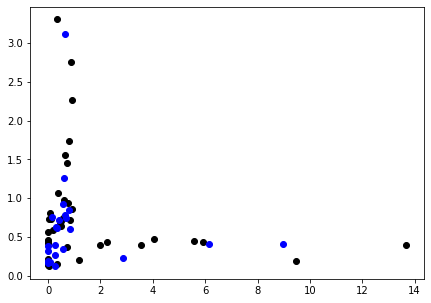

In [16]:
%%time

import pdb

kernel = stheno.Matern52().stretch(0.25)
#gen = convcnp.data.GPGenerator(kernel=kernel)
gen = convcnp.data_hydro.HydroGenerator(s_year=2000,s_month=6,s_day=1,e_year=2000,e_month=9,e_day=30,dataframe=df,max_train_points=40,max_test_points=40)
#gen = convcnp.data.SawtoothGenerator()

#x_test = np.linspace(2000*365 + 30*6 + 1, 2000*365 + 30*6 + 30, 300)
x_test = np.linspace(0,1,90)
#x_test = np.linspace(-2,2,300)
gp = stheno.GP(kernel)

def plot_task(task, idx, legend):
    x_context, y_context = to_numpy(task['x_context'][idx]), to_numpy(task['y_context'][idx])
    x_target, y_target = to_numpy(task['x_target'][idx]), to_numpy(task['y_target'][idx])
    #x_context, y_context = to_numpy(task['x_context'][idx][:,0]), to_numpy(task['y_context'][idx])
    #x_target, y_target = to_numpy(task['x_target'][idx][:,0]), to_numpy(task['y_target'][idx])

    #pdb.set_trace()

    # Plot context and target sets.
    plt.scatter(x_context[:,0], y_context, label='Context Set', color='black')
    plt.scatter(x_target[:,0], y_target, label = 'Target Set', color='blue')
    
    # Infer GP posterior.
    post = gp  | (x_context[:,0], y_context)
    
    # Make and plot predictions on desired range.
    gp_mean, gp_lower, gp_upper = post(x_test).marginals()
    plt.plot(x_test, gp_mean, color='tab:green', label='Oracle GP')
    plt.fill_between(x_test, gp_lower, gp_upper, color='tab:green', alpha=0.1)
    if legend:
        plt.legend()

task = gen.generate_task()

fig = plt.figure(figsize=(24, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_task(task, i, legend=i==2)
plt.show()

In the above plots, the black points are the observed context set, and the green curve is the predictive function for the posterior Gaussian process (conditioned on the context set), with the _true_ GP kernel.

Next, let's define the core building blocks for the ConvCNP model! 

# Encoder

The encoder for our model will be a `ConvDeepSet` layer. This layer takes as input a set, and embeds it into a function space. The layer will also provide a discretization of the functional representation for the decoder. Further, for convenience, we add an additional, point-wise linear transformation to the functional representation to provide the decoder with the appropriate number of channels. In the module, this is called `self.g`, which is implemented as a simple linear layer, and applied after the discretization. 

In this implementation, we use a RBF kernel with a learned length-scale as the $\psi$ function, which takes as input the distance between two input locations, and returns a scalar. Note that $\psi$ can be any differentiable function of this form, e.g., implemented as an MLP. The method `self.rbf` implements $\psi$ in this example. The helper function `compute_dists` computes the pair-wise distances between vectors of input locations.

The forward method for this module accepts as inputs a context set -- $x$ and $y$ -- each of which is an order 3 tensor (batch size, num context points, `dim(x) / dim(y)`), and an additional order 3 tensor of locations ($x_{out}$) at which to evaluate the functional representation of the context set (this is the discretization for the decoder). It returns the values of the function at the locations $x_{out}$ for each of the tasks in the batch.


In [0]:
def compute_dists_1D(x, y):
    """Fast computation of pair-wise distances for the 1d case.
    
    Args:
        x (tensor): Inputs of shape (batch, n, 1).
        y (tensor): Inputs of shape (batch, m, 1).

    Returns:
        tensor: Pair-wise distances of shape (batch, n, m).
    """
    return (x - y.permute(0, 2, 1)) ** 2


def compute_dists(x_context, x_target):
        '''
        Compute dists for psi for 2D
        '''
        t1 = (x_context[:, :, 0:1] - x_target.permute(0, 2, 1)[:, 0:1, :])**2
        t2 = (x_context[:, :, 1:2] - x_target.permute(0, 2, 1)[:, 1:2, :])**2
        
        return (t1 + t2)

class ConvDeepSet(nn.Module):
    """One-dimensional ConvDeepSet module. Uses an RBF kernel for psi(x, x').

    Args:
        out_channels (int): Number of output channels.
        init_length_scale (float): Initial value for the length scale.
    """

    def __init__(self, out_channels, init_length_scale):
        super(ConvDeepSet, self).__init__()
        self.out_channels = out_channels
        self.in_channels = 2
        self.g = self.build_weight_model()
        self.sigma = nn.Parameter(np.log(init_length_scale) *
                                  torch.ones(self.in_channels), requires_grad=True)
        self.sigma_fn = torch.exp

    def build_weight_model(self):
        """Returns a function point-wise function that transforms the
        (in_channels + 1)-dimensional representation to dimensionality
        out_channels.

        Returns:
            torch.nn.Module: Linear layer applied point-wise to channels.
        """
        model = nn.Sequential(
            nn.Linear(self.in_channels, self.out_channels),
        )
        init_sequential_weights(model)
        return model
    
    def rbf(self, dists):
        """Compute the RBF values for the distances using the correct length
        scales.

        Args:
            dists (tensor): Pair-wise distances between x and t.

        Returns:
            tensor: Evaluation of psi(x, t) with psi an RBF kernel.
        """
        # Compute the RBF kernel, broadcasting appropriately.
        scales = self.sigma_fn(self.sigma)[None, None, None, :]
        a, b, c = dists.shape
        return torch.exp(-0.5 * dists.view(a, b, c, -1) / scales ** 2)

    def forward(self, x, y, t):
        """Forward pass through the layer with evaluations at locations t.

        Args:
            x (tensor): Inputs of observations of shape (n, 1).
            y (tensor): Outputs of observations of shape (n, in_channels).
            t (tensor): Inputs to evaluate function at of shape (m, 1).

        Returns:
            tensor: Outputs of evaluated function at z of shape
                (m, out_channels).
        """
        # Compute shapes.
        batch_size = x.shape[0]
        n_in = x.shape[1]
        n_out = t.shape[1]

        # Compute the pairwise distances.
        # Shape: (batch, n_in, n_out).
        dists = compute_dists(x, t)

        # Compute the weights.
        # Shape: (batch, n_in, n_out, in_channels).
        wt = self.rbf(dists)

        # Compute the extra density channel.
        # Shape: (batch, n_in, 1).
        density = torch.ones(batch_size, n_in, 1).to(device)

        # Concatenate the channel.
        # Shape: (batch, n_in, in_channels + 1).
        y_out = torch.cat([density, y], dim=2)

        # Perform the weighting.
        # Shape: (batch, n_in, n_out, in_channels + 1).
        y_out = y_out.view(batch_size, n_in, -1, self.in_channels) * wt

        # Sum over the inputs.
        # Shape: (batch, n_out, in_channels + 1).
        y_out = y_out.sum(1)

        # Use density channel to normalize convolution.
        density, conv = y_out[..., :1], y_out[..., 1:]
        normalized_conv = conv / (density + 1e-8)
        y_out = torch.cat((density, normalized_conv), dim=-1)

        # Apply the point-wise function.
        # Shape: (batch, n_out, out_channels).
        y_out = y_out.view(batch_size * n_out, self.in_channels)
        y_out = self.g(y_out)
        y_out = y_out.view(batch_size, n_out, self.out_channels)

        return y_out

## Decoder 

The decoder (denoted $\rho$ in the paper) is any appropriate convolutional architecture. We provide two example architectures in the [convcnp.architectures](https://github.com/cambridge-mlg/convcnp/blob/master/convcnp/architectures.py) file that are used in the paper, but users should feel free to design and implement any architectures that seem appropriate. For example, in experiments not published, we have found that using depth-wise-separable convolutions can lead to performance gains as well as significant reductions in the number of model parameters. In this example, we will use the UNet architecture employed by ConvCNP XL in the paper, which can be imported from [convcnp.architectures](https://github.com/cambridge-mlg/convcnp/blob/master/convcnp/architectures.py). 

Finally, for the 1d case, we require an additional layer(s) on top of $\rho$ to map back to the continuous setting (i.e., evaluate the output at any desired location). For this layer, we will use a layer that is similar to ConvDeepSet, involving another RBF function, $\psi_{\rho}$. However, it does not require any use of the density channel. Such a layer is constructed below.

In [0]:
class FinalLayer(nn.Module):
    """One-dimensional Set convolution layer. Uses an RBF kernel for psi(x, x').

    Args:
        in_channels (int): Number of inputs channels.
        init_length_scale (float): Initial value for the length scale.
    """

    def __init__(self, in_channels, init_length_scale):
        super(FinalLayer, self).__init__()
        self.out_channels = 1
        self.in_channels = in_channels
        self.g = self.build_weight_model()
        self.sigma = nn.Parameter(np.log(init_length_scale) * torch.ones(self.in_channels), requires_grad=True)
        self.sigma_fn = torch.exp

    def build_weight_model(self):
        """Returns a function point-wise function that transforms the
        (in_channels + 1)-dimensional representation to dimensionality
        out_channels.

        Returns:
            torch.nn.Module: Linear layer applied point-wise to channels.
        """
        model = nn.Sequential(
            nn.Linear(self.in_channels, self.out_channels),
        )
        init_sequential_weights(model)
        return model
    
    def rbf(self, dists):
        """Compute the RBF values for the distances using the correct length
        scales.

        Args:
            dists (tensor): Pair-wise distances between x and t.

        Returns:
            tensor: Evaluation of psi(x, t) with psi an RBF kernel.
        """
        # Compute the RBF kernel, broadcasting appropriately.
        scales = self.sigma_fn(self.sigma)[None, None, None, :]
        a, b, c = dists.shape
        return torch.exp(-0.5 * dists.view(a, b, c, -1) / scales ** 2)

    def forward(self, x, y, t):
        """Forward pass through the layer with evaluations at locations t.

        Args:
            x (tensor): Inputs of observations of shape (n, 1).
            y (tensor): Outputs of observations of shape (n, in_channels).
            t (tensor): Inputs to evaluate function at of shape (m, 1).

        Returns:
            tensor: Outputs of evaluated function at z of shape
                (m, out_channels).
        """
        # Compute shapes.
        batch_size = x.shape[0]
        n_in = x.shape[1]
        n_out = t.shape[1]

        # Compute the pairwise distances.
        # Shape: (batch, n_in, n_out).
        pdb.set_trace()
        dists = compute_dists(x, t)

        # Compute the weights.
        # Shape: (batch, n_in, n_out, in_channels).
        wt = self.rbf(dists)

        # Perform the weighting.
        # Shape: (batch, n_in, n_out, in_channels).
        y_out = y.view(batch_size, n_in, -1, self.in_channels) * wt

        # Sum over the inputs.
        # Shape: (batch, n_out, in_channels).
        y_out = y_out.sum(1)

        # Apply the point-wise function.
        # Shape: (batch, n_out, out_channels).
        y_out = y_out.view(batch_size * n_out, self.in_channels)
        y_out = self.g(y_out)
        y_out = y_out.view(batch_size, n_out, self.out_channels)

        return y_out



## Complete Model

We are now ready to construct the ConvCNP model! Upon initialization, the model takes two arguments: the convolutional architecture to use for $\rho$, and the number of points (per unit interval) at which to evaluate the functional representation. The model will internally compute the exact discretization based on the context and target sets and this parameter, by spacing points evenly across an interval. The model also performs several other internal computations upon initialization, such as computing the intialization of the length scale for the RBF kernels in $\psi$ and the output layer function $\psi_{\rho}$. 

In the forward pass, the model takes the context set (again represented as 3-tensors for $x$ and $y$), and the locations for the target set at which it should make predictions ($x_{out}$). It first determines the locations at which to evaluate the functional representation. Then, the encoder computes the functional representation and returns the values at the locations determined by the model. Finally, these locations are passed to $\rho$, which produces a Gaussian prediction at each of the desired locations in the target set.

In [0]:
%%capture
import pdb
class ConvCNP(nn.Module):
    """One-dimensional ConvCNP model.

    Args:
        learn_length_scale (bool): Learn the length scale.
        points_per_unit (int): Number of points per unit interval on input.
            Used to discretize function.
    """

    def __init__(self, rho, points_per_unit):
        super(ConvCNP, self).__init__()
        self.activation = nn.Sigmoid()
        self.sigma_fn = nn.Softplus()
        self.rho = rho
        self.multiplier = 2 ** self.rho.num_halving_layers

        # Compute initialisation.
        self.points_per_unit = points_per_unit
        init_length_scale = 2.0 / self.points_per_unit
        
        # Instantiate encoder
        self.encoder = ConvDeepSet(out_channels=self.rho.in_channels,
                                   init_length_scale=init_length_scale)
        
        # Instantiate mean and standard deviation layers
        self.mean_layer = FinalLayer(in_channels=self.rho.out_channels,
                                     init_length_scale=init_length_scale)
        self.sigma_layer = FinalLayer(in_channels=self.rho.out_channels,
                                      init_length_scale=init_length_scale)

    def forward(self, x, y, x_out):
        """Run the model forward.

        Args:
            x (tensor): Observation locations of shape (batch, data, features).
            y (tensor): Observation values of shape (batch, data, outputs).
            x_out (tensor): Locations of outputs of shape (batch, data, features).
            
        Returns:
            tuple[tensor]: Means and standard deviations of shape (batch_out, channels_out).
        """
        # Determine the grid on which to evaluate functional representation.
        x_min = min(torch.min(x).cpu().numpy(),
                    torch.min(x_out).cpu().numpy(), -2.) - 0.1
        x_max = max(torch.max(x).cpu().numpy(),
                    torch.max(x_out).cpu().numpy(), 2.) + 0.1
        num_points = int(to_multiple(self.points_per_unit * (x_max - x_min),
                                     self.multiplier))
        x_grid = torch.linspace(x_min, x_max, num_points).to(device)

        pdb.set_trace()

        x_grid = x_grid[None, :, None].repeat(x.shape[0], 1, 1)

        # Apply first layer and conv net. Take care to put the axis ranging
        # over the data last.
        h = self.activation(self.encoder(x, y, x_grid))
        h = h.permute(0, 2, 1)
        h = h.reshape(h.shape[0], h.shape[1], num_points)
        h = self.rho(h)
        h = h.reshape(h.shape[0], h.shape[1], -1).permute(0, 2, 1)

        # Check that shape is still fine!
        if h.shape[1] != x_grid.shape[1]:
            raise RuntimeError('Shape changed.')

        # Produce means and standard deviations.
        mean = self.mean_layer(x_grid, h, x_out)
        sigma = self.sigma_fn(self.sigma_layer(x_grid, h, x_out))

        return mean, sigma

    @property
    def num_params(self):
        """Number of parameters in model."""
        return np.sum([torch.tensor(param.shape).prod()
                       for param in self.parameters()])
    

model = ConvCNP(rho=UNet(), points_per_unit=64)
model.to(device)

## Training Methods

With our model in place, let's next define a training procedure. The `train` function below performs one training epoch (as defined by the number of tasks in an epoch from our data generator) as follows:
1. Iterate over the tasks in the epoch
2. For every task, condition on the context set, and make (Gaussian) predictions at the target locations.
3. Compute the log-likelihood of the predictions under the target set.
4. Backpropagate the error from the (negative) log-likelihood to the model parameters 

The `RunningAverage` average object will maintain a running average of the negative log-likelihood. In addition, we provide a plotting function so as to visually monitor the progress of the training procedure.

In [0]:
import pdb
def train(data, model, opt):
    """Perform a training epoch."""
    ravg = RunningAverage()
    model.train()
    for step, task in enumerate(data):
        #pdb.set_trace()
        y_mean, y_std = model(task['x_context'], task['y_context'], task['x_target'])
        obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
        obj.backward()
        opt.step()
        opt.zero_grad()
        ravg.update(obj.item() / data.batch_size, data.batch_size)
    return ravg.avg

# Create a fixed set of outputs to predict at when plotting.

#x_test = torch.linspace(-2., 2., 200)[None, :, None].to(device)
#x_test = torch.linspace(0., 365., 365)[None, :, None].to(device)
x_test = torch.linspace(0., 1., 60)[None, :, None].to(device)

def plot_model_task(model, task, idx, legend):
    num_functions = task['x_context'].shape[0]
    
    # Make predictions with the model.
    model.eval()
    with torch.no_grad():
        y_mean, y_std = model(task['x_context'], task['y_context'], x_test.repeat(num_functions, 1, 1))
    
    # Plot the task and the model predictions.
    x_context, y_context = to_numpy(task['x_context'][idx]), to_numpy(task['y_context'][idx])
    x_target, y_target = to_numpy(task['x_target'][idx]), to_numpy(task['y_target'][idx])
    y_mean, y_std = to_numpy(y_mean[idx]), to_numpy(y_std[idx])
    
    # Plot context and target sets.
    plt.scatter(x_context, y_context, label='Context Set', color='black')
    plt.scatter(x_target, y_target, label='Target Set', color='red')
    
    # Plot model predictions.
    plt.plot(to_numpy(x_test[0]), y_mean, label='Model Output', color='blue')
    plt.fill_between(to_numpy(x_test[0]),
                     y_mean + 2 * y_std,
                     y_mean - 2 * y_std,
                     color='tab:blue', alpha=0.2)
    if legend:
        plt.legend()


## Training loop for the model

Now we can write a standard PyTorch optimization loop. First, we instantiate an optimizer (here we use an Adam optimizer). Then, we simply iterate for as many epochs as necessary to train the model. Every so often we will print the training error (since the data are generated on the fly, this is also a reasonable estimator for the held out error), and produce a plot demonstrating the model performance. Note that the next block of code will train the model for 100 epochs. This may take some time, and it is highly recommended to do so with a GPU!

In [0]:
%%time
# Some training hyper-parameters:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
PLOT_FREQ = 1

# Initialize optimizer
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Run the training loop.
for epoch in range(NUM_EPOCHS):

    #print ('MGM Epoch %s: NLL %.3f' % (epoch, train_obj))  
    # Compute training objective.
    train_obj = train(gen, model, opt)

    # Plot model behaviour every now and again.
    if epoch % PLOT_FREQ == 0:
        print('Epoch %s: NLL %.3f' % (epoch, train_obj))
        task = gen.generate_task()
        fig = plt.figure(figsize=(24, 5))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plot_model_task(model, task, idx=i, legend=i==2)
        plt.show()
    else:
        print('Epoch %s: NLL %.3f' % (epoch, train_obj))


> <ipython-input-33-12f37fb59b63>(54)forward()
-> x_grid = x_grid[None, :, None].repeat(x.shape[0], 1, 1)
*** TypeError: 'torch.Size' object is not callable
*** NameError: name 'shape' is not defined
16
torch.Size([16, 21, 2])
*** NameError: name 't' is not defined
*** TypeError: tuple indices must be integers or slices, not tuple
*** TypeError: tuple indices must be integers or slices, not tuple
tensor([[[6.8595e-01],
         [1.5702e-01],
         [1.9835e-01],
         [1.3223e-01],
         [4.6281e-01],
         [9.7521e-01],
         [7.4380e-01],
         [6.7769e-01],
         [0.0000e+00],
         [8.2645e-01],
         [5.1900e+00],
         [0.0000e+00],
         [3.3600e+00],
         [5.5900e+00],
         [5.1000e-01],
         [7.2300e+00],
         [2.6000e-01],
         [1.2990e+01],
         [1.1700e+00],
         [4.3000e-01],
         [0.0000e+00]],

        [[7.5207e-01],
         [4.5455e-01],
         [4.2975e-01],
         [8.7603e-01],
         [9.2562e-01],


## Evaluation 

We can also evaluate the trained model to get better estimates of its performance. To do so, we will first introduce an additional data generator that will generate far more tasks for us. Then, we will loop over many tasks, and compute (and print) the average log-likelihood.

In [0]:
# Instantiate data generator for testing.
NUM_TEST_TASKS = 2048
gen_test = convcnp.data.GPGenerator(kernel=kernel, num_tasks=NUM_TEST_TASKS)

# Compute average task log-likelihood.
ravg = RunningAverage()
model.eval()
with torch.no_grad():
    for step, task in enumerate(gen_test):
        y_mean, y_std = model(task['x_context'], task['y_context'], task['x_target'])
        obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
        ravg.update(obj.item() / gen_test.batch_size, gen_test.batch_size)

print('Model averages a log likelihood of %.2f on unseen tasks.' % -ravg.avg)